In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
data = np.loadtxt('../large_files/train.csv', delimiter=',', skiprows=1, dtype=int)

def set_up_data(d):
    # shuffle the data
    np.random.shuffle(d)

    # split into X and Y (labels are first column)
    X = d[:, 1:]
    Y = d[:, 0]

    # split into train/test
    r, c = np.shape(d)
    r_90 = r // 90
    X_train, X_test = X[:-r_90], X[-r_90:]
    Y_train, Y_test = Y[:-r_90], Y[-r_90:]

    # normalize.
    # takes mean/std for each col (??)
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    # for all-black images (std == 0), change std to 1 to prevent /0 errors
    idx = np.where(std == 0)[0]
    assert(np.all(std[idx]) == 0)

    np.place(std, std == 0, 1)

    X_train = (X_train - mu) / std
    X_test = (X_test - mu) / std
    
    return X_train, X_test, Y_train, Y_test

def onehot_encode(y):
    N = len(y)
    min_y, max_y = np.min(y), np.max(y)
    K = (max_y - min_y) + 1

    encoded_y = np.zeros((N, K))

    for i in range(N):
        col_val = y[i]
        encoded_y[i, col_val] = 1
    
    return encoded_y

def error_rate(p, t):
    return np.mean(p != t)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-04-30 12:09:25.584473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Cost / err at iteration i=0, j=0: 1121.746 / 0.895
Cost / err at iteration i=0, j=50: 181.639 / 0.112
Cost / err at iteration i=1, j=0: 144.586 / 0.079
Cost / err at iteration i=1, j=50: 114.687 / 0.071
Cost / err at iteration i=2, j=0: 98.835 / 0.058
Cost / err at iteration i=2, j=50: 82.207 / 0.056
Cost / err at iteration i=3, j=0: 72.040 / 0.047
Cost / err at iteration i=3, j=50: 66.080 / 0.039
Cost / err at iteration i=4, j=0: 58.952 / 0.036
Cost / err at iteration i=4, j=50: 55.270 / 0.032
Cost / err at iteration i=5, j=0: 50.216 / 0.032
Cost / err at iteration i=5, j=50: 48.841 / 0.026
Cost / err at iteration i=6, j=0: 45.440 / 0.028
Cost / err at iteration i=6, j=50: 44.368 / 0.021
Cost / err at iteration i=7, j=0: 42.670 / 0.024
Cost / err at iteration i=7, j=50: 41.634 / 0.030
Cost / err at iteration i=8, j=0: 40.211 / 0.024
Cost / err at iteration i=8, j=50: 40.225 / 0.028
Cost / err at iteration i=9, j=0: 38.818 / 0.028
Cost / err at iteration i=9, j=50: 39.254 / 0.026
Cost 

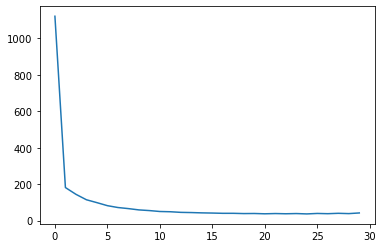

In [19]:
def main():
    # step 1: get the data and define all the usual variables
    Xtrain, Xtest, Ytrain, Ytest = set_up_data(data)

    max_iter = 15
    print_period = 50

    lr = 0.00004
    reg = 0.01

    Ytrain_ind = onehot_encode(Ytrain)
    Ytest_ind = onehot_encode(Ytest)

    N, D = Xtrain.shape
    batch_sz = 500
    n_batches = N // batch_sz

    # add an extra layer just for fun
    M1 = 300
    M2 = 100
    K = 10
    W1_init = np.random.randn(D, M1) / np.sqrt(D) # the division step regularizes the data
    b1_init = np.zeros(M1)
    W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
    b2_init = np.zeros(M2)
    W3_init = np.random.randn(M2, K) / np.sqrt(M2)
    b3_init = np.zeros(K)


    # define variables and expressions
    X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    T = tf.placeholder(tf.float32, shape=(None, K), name='T')
    W1 = tf.Variable(W1_init.astype(np.float32))
    b1 = tf.Variable(b1_init.astype(np.float32))
    W2 = tf.Variable(W2_init.astype(np.float32))
    b2 = tf.Variable(b2_init.astype(np.float32))
    W3 = tf.Variable(W3_init.astype(np.float32))
    b3 = tf.Variable(b3_init.astype(np.float32))

    # define the model
    Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
    Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
    Yish = tf.matmul(Z2, W3) + b3 # remember, the cost function does the softmaxing! weird, right?

    # softmax_cross_entropy_with_logits take in the "logits"
    # if you wanted to know the actual output of the neural net,
    # you could pass "Yish" into tf.nn.softmax(logits)
    cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T))

    # we choose the optimizer but don't implement the algorithm ourselves
    # let's go with RMSprop, since we just learned about it.
    # it includes momentum!
    train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

    # we'll use this to calculate the error rate
    predict_op = tf.argmax(Yish, 1)

    costs = []
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)

        for i in range(max_iter):
            for j in range(n_batches):
                Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                    prediction = session.run(predict_op, feed_dict={X: Xtest})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    costs.append(test_cost)

    plt.plot(costs)
    plt.show()
    # increase max_iter and notice how the test cost starts to increase.
    # are we overfitting by adding that extra layer?
    # how would you add regularization to this model?


if __name__ == '__main__':
    main()